# Always Run

In [1]:
%matplotlib notebook
#!pip install ipympl
#%matplotlib widget
#%matplotlib inline
#%matplotlib tk
#%matplotlib qt

In [2]:
import qcodes as qc
## Multidimensional scanning module
from qcodes.dataset import (
    LinSweep,
    Measurement,
    dond,
    experiments,
    initialise_or_create_database_at,
    load_by_run_spec,
    load_or_create_experiment,
    plot_dataset,
)
## Using interactive widget
from qcodes.interactive_widget import experiments_widget
from qcodes.parameters import ScaledParameter, Parameter

from FridgeStation import Fridge, module_and_phase, goToVoltage, goToGround, mfli_module, mfli_phase, my_str
from DriverStahl import Stahl, StahlChannel
from DriverKeithley2110 import Keithley2110
from IPS120 import OxfordInstruments_IPS120

from zhinst.toolkit import Session

import numpy as np
import seaborn as sns
from math import ceil
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Button, CheckButtons
from tqdm import tqdm # Used for displaying a progress bar
from datetime import datetime #datetime class from datetime package
plt.rcParams.update({'font.size': 15})
import pyqtgraph as pg
from PyQt5.QtWidgets import QApplication
from PyQt5.QtCore import QTimer
import numpy as np
import threading
import time
from matplotlib.widgets import Button


## Calibration curve of the $RuO_2$ thermometer

In [4]:
def calibration(R):
#     if R > 2446.94: # 0.05 to 0.95 K
#         Z1 = np.log10(R)
#         ZL1 = 3.35453159798 ; ZU1 = 5.00000000000
#         k1 = ((Z1-ZL1) - (ZU1-Z1)) / (ZU1-ZL1)
#         A1 = np.array([0.300923,-0.401714, 0.220055,-0.098891, 0.046804,-0.017379, 0.009090,-0.002703, 0.002170])
#         T = np.polynomial.chebyshev.chebval(k1, A1)
#     elif R > 1247.71: # 0.95 to 6.5 K
#         Z2 = np.log10(R)
#         ZL2 = 3.08086045368 ; ZU2 = 3.44910010859
#         k2 = ((Z2-ZL2) - (ZU2-Z2)) / (ZU2-ZL2)
#         A2 = np.array([2.813252,-2.976371, 1.299095,-0.538334, 0.220456,-0.090969, 0.037095,-0.015446, 0.005104,-0.004254])
#         T = np.polynomial.chebyshev.chebval(k2, A2)
#     else: # 6.5 to 40 K
#         Z3 = np.log10(R)
#         ZL3 = 2.95500000000 ; ZU3 = 3.10855552727
#         k3 = ((Z3-ZL3) - (ZU3-Z3)) / (ZU3-ZL3)
#         A3 = np.array([3074.395992,-5680.735415, 4510.873058,-3070.206226, 1775.293345, -857.606658, 336.220971, -101.617491, 21.390256, -2.407847])
#         T = np.polynomial.chebyshev.chebval(k3, A3)
#     return T
    ln_T = -2.6553952011*np.log(-8.1866484759+0.98155249557*np.log(R))
    T = np.exp(ln_T)
    return T

In [5]:
# N = 1000
# R = np.linspace(7000, 65000, N) ; T = np.zeros(N)
# #R1 = np.linspace(63765.1, 2446.94, N) ; T1 = np.zeros(N)
# #R2 = np.linspace(2446.94, 1247.71, N) ; T2 = np.zeros(N)
# #R3 = np.linspace(1247.71, 1049.08, N) ; T3 = np.zeros(N)
# for i in range(N):
#     T[i] = calibration(R[i])
#     #T1[i] = calibration(R1[i])
#     #T2[i] = calibration(R2[i])
#     #T3[i] = calibration(R3[i])

# fig, ax = plt.subplots(figsize = (10, 6.18))

# ax.plot(T,R)
# #ax.plot(T1, R1)
# #ax.plot(T2, R2)
# #ax.plot(T3, R3)

# ax.set_ylabel("Resistance ($\Omega$)")
# ax.set_xlabel("Temperature (K)")
# #ax.set_xscale("log")
# ax.set_yscale("log")

# ax.grid(alpha = 0.3, ls = "--")

# plt.show()

## Preparing the experiment

## Creation of the *station*

A station is a collection of all the instruments and devices present in your experiment

In [9]:
station = Fridge() # Creates an instantiation from the "Fridge" class

dmm_dict    = {"name":"Keithley_leakage", "address":"GPIB0::16::INSTR"}
mfli_dict   = {"serial":["dev4451","dev3213","dev7605"], "dataserver":"localhost"}
HV_dict     = {"name":"HV062",            "address":"COM14"           }
LV_dict     = {"name":"HV090",            "address":"COM2"            }
magnet_dict = {"name":"IPS120",           "address":"GPIB2::30::INSTR"}

dmm, mflis, daq_mfli, HV, LV, magnet = station.default_initialisation(dmm_dict = dmm_dict, mfli_dict = mfli_dict, HV_dict = HV_dict, LV_dict = LV_dict, magnet_dict = magnet_dict)

mfli4451 = mflis[0]
mfli3213 = mflis[1]
mfli7605 = mflis[2]

Connected to: KEITHLEY INSTRUMENTS INC. 2700 (serial:0755493, A01  /A02) in 1.07 s
Connected to: Zurich Instruments MFLI (serial:dev4451, firmware:69778) in 0.25s
Connected to: Zurich Instruments MFLI (serial:dev3213, firmware:69778) in 0.22s
Connected to: Zurich Instruments MFLI (serial:dev7605, firmware:69778) in 0.20s
Connected to: HV062 with 2 channels and reaching 200V in 0.07 s
Connected to: HV090 with 4 channels and reaching 14V in 0.03 s
Connected to: Oxford Instruments IPS120 (serial:None, firmware:None) in 0.27s


In [15]:
# # Creates a station without a magnet

# station = Fridge() # Creates an instantiation from the "Fridge" class

# dmm_dict = {"name":"Keithley_leakage", "address":"GPIB0::16::INSTR"}
# mfli_dict = {"serial":["dev4451","dev3213","dev7605"], "dataserver":"localhost"}
# HV_dict = {"name":"HV062", "address":"COM14"}
# LV_dict = {"name":"HV090", "address":"COM2"}

# dmm, mflis, daq_mfli, HV, LV = station.default_initialisation(dmm_dict = dmm_dict, mfli_dict = mfli_dict, HV_dict = HV_dict, LV_dict = LV_dict)

# mfli4451 = mflis[0]
# mfli3213 = mflis[1]
# mfli7605 = mflis[2]

### Multimeter

In [18]:
dmm.DCvoltage() # Digital multimeter used for measuring leakage current
Vleak = dmm.amplitude
Rleak = 1e9 # 1Gohms resistance put in series with the gate
conversion = 1/Rleak
Ileak = ScaledParameter(Vleak, gain=conversion, name = "Ileak", unit = "A") # R = V/Ithermometer in kOhms

In [20]:
dmm.amplitude()

0.000312547607

### HV & LV DC sources

In [23]:
HVch = HV.channels[0]
print("High voltage = " + str(HVch.voltage()) + "V")
LVch = LV.channels[1]
print("Low voltage = " + str(LVch.voltage()) + "V")

High voltage = 0.1V
Low voltage = -0.0V


### MFLI

In [26]:
Isample = 1e-9 # Current we want to pass in the sample
Rseries = 10e6 # Resistance in series with the sample
Vout = Rseries*Isample
print(Vout)

Ithermometer = 1e-9
RseriesThermometer = 100e6
Vthermometer = RseriesThermometer * Ithermometer
print(Vthermometer)

0.01
0.1


#### $V_{xx}$ & $I_{xx}$

In [182]:
tc = 0.1
f  = 71

mfli4451.oscs.freq(f) # Sets the frequency of the 4 oscillators

mfli4451.demods.oscselect(0) # The 4 demodulators are demodulated with the first oscillator frequency
mfli4451.demods.timeconstant(tc) # Changes tc for all oscillators
mfli4451.demods[0,1].enable(1) # Turns on demodulators
mfli4451.demods[2,3].enable(0) # Turns off demodulators
mfli4451.demods[0].adcselect(0) # First demodulator is signal in
mfli4451.demods[1].adcselect(1) # Second demodulator is current in

# We only have 1 voltage input, but still we precise sigins[0]
mfli4451.sigins[0].autorange(1) # Autorange for signal in
mfli4451.sigins[0].diff(1)      # Activates differential voltage

# We only have 1 current input, but still we precise currins[0]
mfli4451.currins[0].autorange(1) # Autorange for current in

# We only have 1 voltage output, but still we precise sigouts[0]
mfli4451.sigouts[0].range(Vout*10)
mfli4451.sigouts[0].amplitudes[0].value(Vout*np.sqrt(2)) # Sets the peak to peak amplitude
mfli4451.sigouts[0].amplitudes[1,2,3].value(0)
mfli4451.sigouts[0].enables[0].value(1) # Activates the first output
mfli4451.sigouts[0].enables[1,2,3].value(0) # Deactivates all other outputs
mfli4451.sigouts[0].autorange(1)
mfli4451.sigouts[0].on(1)

#### $V_{xy}$

In [185]:
mfli7605.oscs.freq(f)

mfli7605.demods.oscselect(0) # The 4 demodulators are demodulated with the first oscillator frequency
mfli7605.demods.timeconstant(tc) # Changes tc for all oscillators
mfli7605.demods[0].enable(1) # Turns on demodulators
mfli7605.demods[0].adcselect(0) # First demodulator is signal in

mfli7605.sigins[0].autorange(1) # Autorange for signal in
mfli7605.sigins[0].diff(1)      # Activates differential voltage

# We only have 1 voltage output, but still we precise sigouts[0]
mfli7605.sigouts[0].amplitudes[1].value(0) # Sets the peak to peak amplitude
mfli7605.sigouts[0].enables[1].value(0) # Deactivates the output
mfli7605.sigouts[0].autorange(1)
mfli7605.sigouts[0].on(1)

#### $RuO_2$ resistance

In [34]:
mfli3213.oscs.freq(7)

mfli3213.demods.oscselect(0) # The 4 demodulators are demodulated with the first oscillator frequency
mfli3213.demods.timeconstant(3) # Changes tc for all oscillators
mfli3213.demods[0].enable(1) # Turns on demodulators
mfli3213.demods[0].adcselect(0) # First demodulator is signal in

mfli3213.sigins[0].autorange(1) # Autorange for signal in
mfli3213.sigins[0].diff(1)      # Activates differential voltage

mfli3213.sigouts[0].range(Vthermometer*10)
mfli3213.sigouts[0].amplitudes[0].value(Vthermometer*np.sqrt(2)) # Sets the peak to peak amplitude
mfli3213.sigouts[0].amplitudes[1,2,3].value(0)
mfli3213.sigouts[0].enables[0].value(1) # Activates the first output
mfli3213.sigouts[0].enables[1,2,3].value(0) # Deactivates all other outputs
mfli3213.sigouts[0].on(1)

#### Define parameters for the MFLI

In [332]:
# Longitudinal voltage across the constriction
Vc         = mfli_module(mfli = mfli4451, demodulator = 0, name = "Vc") # Parameter giving Vxx
Vc_phase   =  mfli_phase(mfli = mfli4451, demodulator = 0, name = "Vc_phase")
conversion = 1/Isample # Converts the measured voltage into the sample resistance (Ohm)
Rc         = ScaledParameter(Vc, gain=conversion, name = "Rc", unit = "Ohm") # Rxx = Vxx/Isample in kOhms

# Longitudinal current in the sample 
I          = mfli_module(mfli = mfli4451, demodulator = 1, name = "I") # Parameter giving Ixx
I_phase    =  mfli_phase(mfli = mfli4451, demodulator = 1, name = "I_phase")

# Longitudinal voltage across the sample w/o the constriction
V          = mfli_module(mfli = mfli7605, demodulator = 0, name = "V") # Parameter giving Isample
V_phase    =  mfli_phase(mfli = mfli7605, demodulator = 0, name = "V_phase")
R          = ScaledParameter(V, gain=conversion, name = "R", unit = "Ohm") # Rxx = Vxx/Isample in kOhms

# Voltage drop in the thermometer 
Vtherm        = mfli_module(mfli = mfli3213, demodulator = 0, name = "V_thermometer") # Parameter giving Vxx
Vtherm_phase  = mfli_phase (mfli = mfli3213, demodulator = 0, name = "V_thermometer_phase")
conversion    = 1/Ithermometer # Converts the measured voltage into the thermometer resistance (Ohm)
Rtherm        = ScaledParameter(Vtherm, gain=conversion, name = "R_thermometer", unit = "Ohm") # R = V/Ithermometer in kOhms
T             = Parameter(name = "Temperature", label = "Temperature", unit = "K", get_cmd = lambda:calibration(Rtherm()))

C:\Users\labo-admin\Desktop\Mesures TBG\C2N_September24_stack02\FridgeStation.py:114: SyntaxWarning: invalid escape sequence '\d'
  unit = "$\degree$") # Normally used as the axis label when this parameter is graphed, along with unit


KeyError: 'Duplicate parameter name Vc on instrument <ZIBaseInstrument: zi_baseinstrument_dev4451>'

### IPS

Sweep rate field must be below:

0.4 T/min if B < 10 T

0.2 T/min if 10 T < B < 12 T

0.1 T/min if B > 12 T

The sweep rate is automatically changed in the $B$ parameter

## Creation of the *database* containing the data

We set up a database in order to save our data to. QCoDeS implement a SQLite3 database for this purpose.

In [40]:
initialise_or_create_database_at("Database/Sofiane_Michael_TBG02.db")

In [42]:
qc.config.core.db_location

'Database/Sofiane_Michael_TBG02.db'

# Time constant and delay

In [49]:
TBG02_exp_tc = load_or_create_experiment(
    experiment_name="Time constant",
    sample_name="TBG02"
)

In [51]:
contactI1  = 24
contactI2  = 18
contactV1  = 21
contactV2  = 11
contactVxy = 16

In [53]:
# startTC = 1
# stopTC  = 5
# dTC     = 1
# NTC     = ceil((stopTC-startTC)/dTC + 1)
# tc      = np.linspace(startTC, stopTC, NTC)
tc = 1

startHV = 0
stopHV  = 30 #V
dVHV    = 0.5 #V
NHV     = ceil(stopHV/dVHV + 1)
dtHV    = 1

startLV = -0.5
stopLV  = 0.5
dVLV    = 0.02
NLV     = ceil(abs(stopLV-startLV)/dVLV + 1) #number of points in the full sweep
startdt = 1
stopdt  = 10
stepdt  = 1
dtLV    = np.arange(startdt,stopdt,stepdt) #We will multiply it by tc and generate a map
Ndt     = np.size(dtLV)

dt = Parameter(name = "dt", label = "dt", unit = "s", get_cmd = None, set_cmd = None)

print("Sweep will take : " + str(int(NLV*np.sum(dtLV)//60)) + " min " + str(int(NLV*np.sum(dtLV)%60)) + " s" )

Sweep will take : 38 min 15 s


In [119]:
contacts_name = f"_{contactI1}-{contactI2}_{contactV1}-{contactV2}_{contactVxy}"
#tc_name       = f"_{my_str(startTC)}s_{my_str(stopTC)}s_dtc{my_str(dTC)}s"
dt_name       = f"_{my_str(startdt)}s_{my_str(stopdt)}s_dt{my_str(stepdt)}s"
LV_name       = f"_{my_str(startLV)}V_{my_str(stopLV)}V_dV{my_str(dVLV)}"
time_name     = f"_dt{my_str(dtLV)}_tc{my_str(tc)}"
#name = contacts_name + tc_name + LV_name + time_name
name = contacts_name + dt_name + LV_name + time_name

tc_measurement = Measurement(exp=TBG02_exp_tc,
                              station=station,
                              name="Time constant" + name)

In [120]:
dependent_parameters = [Rxx, Vxx_phase, Rxy, Vxy_phase, Ileak, T]

time_constant = mfli4451.demods[0].timeconstant

# Register the independent parameters...
#tc_measurement.register_parameter(time_constant) # Slowest first
tc_measurement.register_parameter(dt)            # Slowest first
tc_measurement.register_parameter(LVch.voltage)  # Fastest last

# ...then register the dependent parameters
for parameter in dependent_parameters :
    #tc_measurement.register_parameter(parameter, setpoints=(time_constant,LVch.voltage))
    tc_measurement.register_parameter(parameter, setpoints=(dt, LVch.voltage,))

#Set shape for acquired data
tc_measurement.set_shapes({str(parameter) : (Ndt,NLV) for parameter in dependent_parameters}) 
#tc_measurement.set_shapes({str(parameter) : NLV for parameter in dependent_parameters}) 

In [121]:
tc_measurement.parameters

{'Rxx': ParamSpecBase('Rxx', 'numeric', 'Rxx', 'Ohm'),
 'dt': ParamSpecBase('dt', 'numeric', 'dt', 's'),
 'HV090_CH02_voltage': ParamSpecBase('HV090_CH02_voltage', 'numeric', 'voltage', 'V'),
 'zi_baseinstrument_dev4451_Vxx_phase': ParamSpecBase('zi_baseinstrument_dev4451_Vxx_phase', 'numeric', 'Phase', '$\degree$'),
 'Rxy': ParamSpecBase('Rxy', 'numeric', 'Rxy', 'Ohm'),
 'zi_baseinstrument_dev7605_Vxy_phase': ParamSpecBase('zi_baseinstrument_dev7605_Vxy_phase', 'numeric', 'Phase', '$\degree$'),
 'Ileak': ParamSpecBase('Ileak', 'numeric', 'Ileak', 'A'),
 'Temperature': ParamSpecBase('Temperature', 'numeric', 'Temperature', 'K')}

In [69]:
# #prepare the system for mapping

# HV_sweep_init = LinSweep(HVch.voltage, 0, stopHV, NHV, dtHV) # Contact doping
# mfli4451.sigins[0].autorange(1) # Autorange for signal in
# mfli7605.sigins[0].autorange(1) # Autorange for signal in
# time.sleep(10)

# dond(
#     HV_sweep_init,                          # 1st independent parameter
#     Rxx,                                    # 1st dependent parameter
#     Vxx_phase,                              # 2nd dependent parameter
#     Rxy,
#     Vxy_phase,
#     Ileak,                                  # 3rd dependent parameter
#     T,                                      # 4th dependent parameter
#     measurement_name= "HVsweep" + name,  # Set the measurement name
#     exp=TBG02_exp_tc,         # Set the experiment to save data to.
#     show_progress=True,                     # Optional progress bar
#     do_plot=False
# )

# LV_sweep_init = LinSweep(LVch.voltage, 0, startLV, NLV//2, dtLV[0]) # Go to the LV start point from 0

# mfli4451.sigins[0].autorange(1) # Autorange for signal in
# mfli7605.sigins[0].autorange(1) # Autorange for signal in
# time.sleep(10)

# dond(
#     LV_sweep_init,                          # 1st independent parameter
#     Rxx,                                    # 1st dependent parameter
#     Vxx_phase,                              # 2nd dependent parameter
#     Rxy,
#     Vxy_phase,
#     Ileak,                                  # 3rd dependent parameter
#     T,                                      # 4th dependent parameter
#     measurement_name="LVsweep" + name,      # Set the measurement name
#     exp=TBG02_exp_tc,         # Set the experiment to save data to.
#     show_progress=True,                     # Optional progress bar
#     do_plot=False
# )

# mfli4451.sigins[0].autorange(1) # Autorange for signal in
# mfli7605.sigins[0].autorange(1) # Autorange for signal in
# time.sleep(10)

# print("Low voltage  :" + str(LVch.voltage()))
# print("High voltage :" + str(HVch.voltage()))

In [123]:
#map_measurement.write_period = 2

#sweep ranges for map
LV_forward_sweep  = np.linspace(startLV, stopLV, NLV) 
LV_backward_sweep = np.linspace(stopLV, startLV, NLV)

with tc_measurement.run(write_in_background=True) as datasaver:
    for i, set_dt in enumerate(dtLV): #magnetic field iteration
        
        #time_constant(set_tc)
        
        #tc_sweep         = []
        dt_sweep         = []
        LVch_sweep       = []
        Rxx_sweep        = []
        Vxx_phase_sweep  = []
        Rxy_sweep        = []
        Vxy_phase_sweep  = []
        Ileak_sweep      = []
        T_sweep          = []
        
        LVsweep = LV_forward_sweep if i%2 == 0 else LV_backward_sweep
        
        time.sleep(20) # Simulates the time during which we change B
        
        for set_LV in LVsweep : #back gate voltage iteration
            
            LVch.voltage(set_LV)
            time.sleep(dtLV[i])
            
            #tc_sweep.append(dtLV[i])
            dt_sweep.append(dtLV[i])
            LVch_sweep.append(set_LV)
            Rxx_sweep.append(Rxx())
            Vxx_phase_sweep.append(Vxx_phase())
            Rxy_sweep.append(Rxy())
            Vxy_phase_sweep.append(Vxy_phase())
            Ileak_sweep.append(Ileak())
            T_sweep.append(T())
            
        if i%2 == 0:
            datasaver.add_result((dt, dt_sweep),                      # 1st independent parameter
                                 (LVch.voltage, LVch_sweep),          # 2nd independent parameter
                                 (Rxx, Rxx_sweep),                    # 1st dependent parameter
                                 (Vxx_phase, Vxx_phase_sweep),        # 2nd dependent parameter
                                 (Rxy, Rxy_sweep),                    # 3nd dependent parameter
                                 (Vxy_phase, Vxy_phase_sweep),        # 4th dependent parameter
                                 (Ileak, Ileak_sweep),                # 5th dependent parameter
                                 (T, T_sweep))                        # 6th dependent parameter
        else:
            datasaver.add_result((dt, dt_sweep[::-1]),                # 1st independent parameter
                                 (LVch.voltage, LVch_sweep[::-1]),    # 2nd independent parameter
                                 (Rxx, Rxx_sweep[::-1]),              # 1st dependent parameter
                                 (Vxx_phase, Vxx_phase_sweep[::-1]),  # 2nd dependent parameter
                                 (Rxy, Rxy_sweep[::-1]),              # 3nd dependent parameter
                                 (Vxy_phase, Vxy_phase_sweep[::-1]),  # 4th dependent parameter
                                 (Ileak, Ileak_sweep[::-1]),          # 5th dependent parameter
                                 (T, T_sweep[::-1]))                  # 6th dependent parameter

    # Convenient to have for plotting and data access
    dataset = datasaver.dataset

Starting experimental run with id: 41. 


<IPython.core.display.Javascript object>


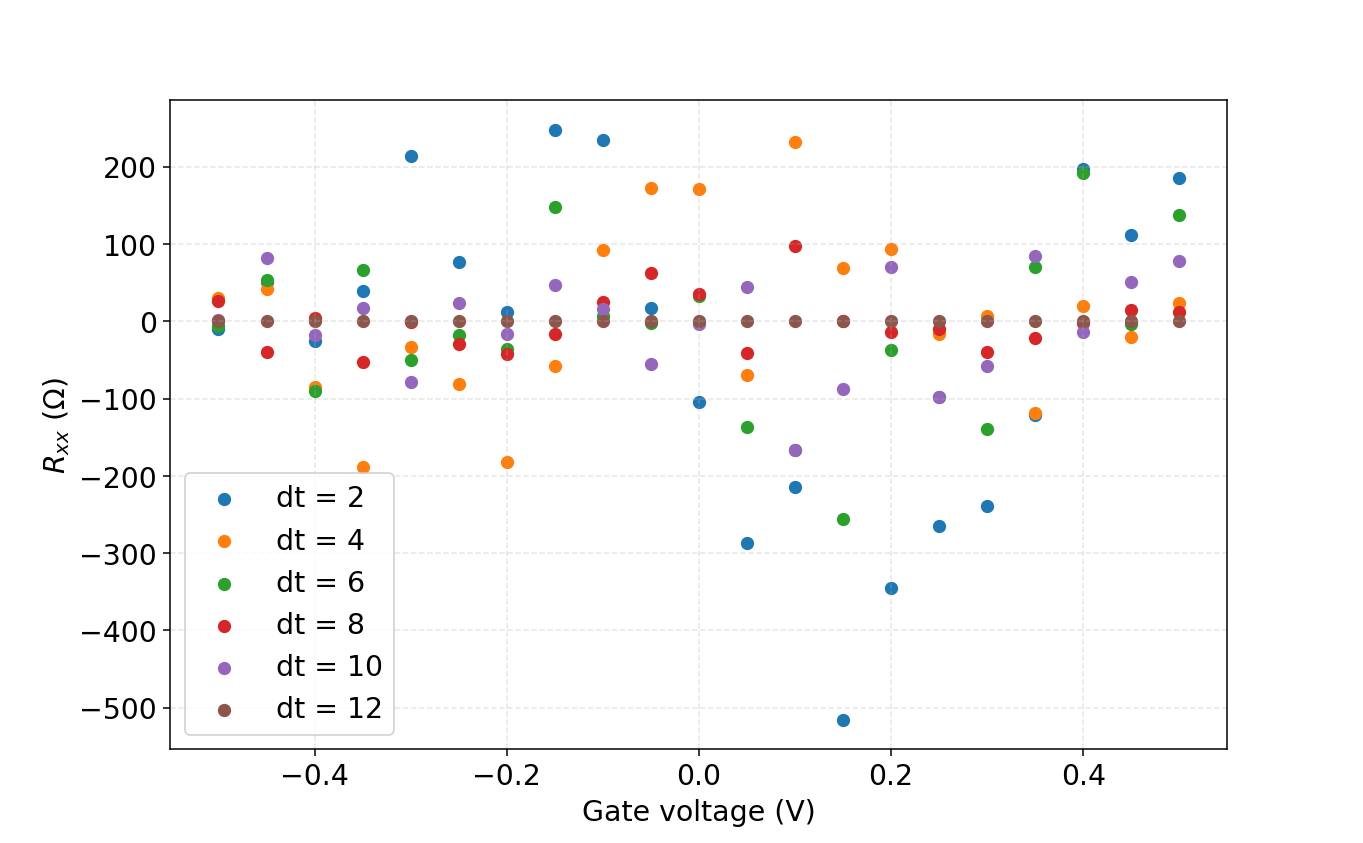

In [113]:
Rxx_data = np.reshape(dataset.get_parameter_data()["Rxx"]["Rxx"], (Ndt, NLV))
dt_data  = np.reshape(dataset.get_parameter_data()["Rxx"]["dt"], (Ndt, NLV))
LV_data  = np.reshape(dataset.get_parameter_data()["Rxx"]["HV090_CH02_voltage"], (Ndt, NLV))

fig, ax = plt.subplots(figsize = (10, 6.18))

for i in range(Ndt):
    ax.scatter(LV_data[i,:], Rxx_data[i,:]-Rxx_data[-1,:], label = f"dt = {dtLV[i]}")
    
ax.set_xlabel("Gate voltage (V)")
ax.set_ylabel("$R_{xx}\ (\Omega)$")

ax.grid(ls = "--", alpha = 0.3)
ax.legend()
plt.show()

<IPython.core.display.Javascript object>


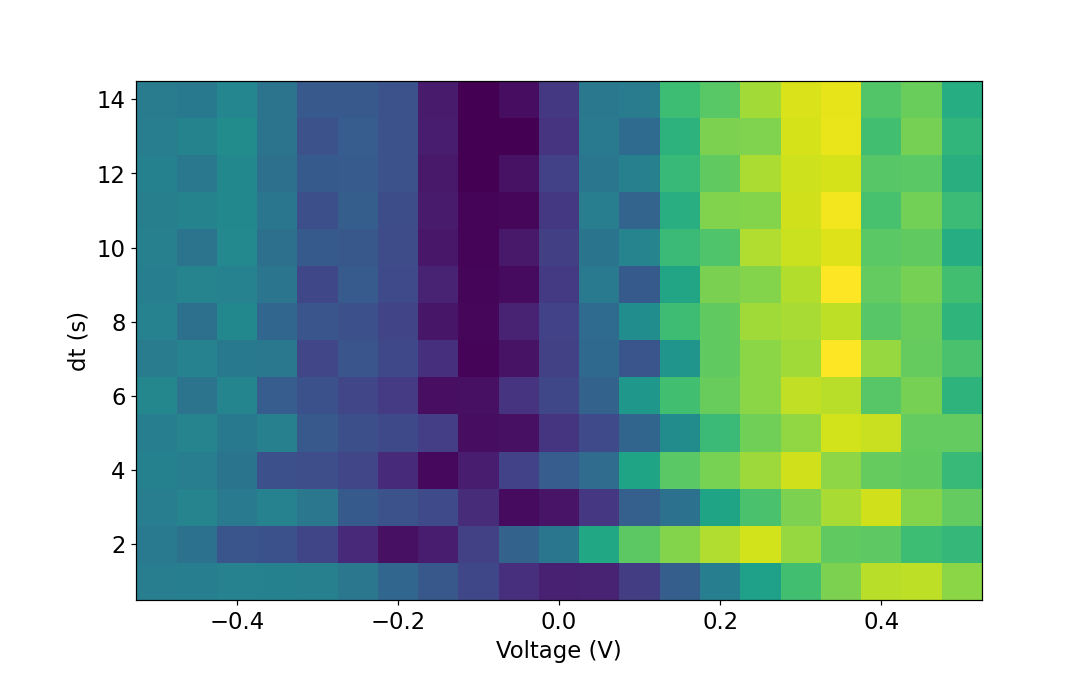

In [124]:
Rxx_data = np.reshape(dataset.get_parameter_data()["Rxx"]["Rxx"], (Ndt, NLV))
dt_data  = np.reshape(dataset.get_parameter_data()["Rxx"]["dt"], (Ndt, NLV))
LV_data  = np.reshape(dataset.get_parameter_data()["Rxx"]["HV090_CH02_voltage"], (Ndt, NLV))

fig, ax = plt.subplots(figsize = (10, 6.18))

ax.pcolormesh(LV_data, dt_data, Rxx_data, shading = "nearest")

ax.set_xlabel("Voltage (V)")
ax.set_ylabel("dt (s)")

plt.show()

In [125]:
print("Low voltage  :" + str(LVch.voltage()))
print("High voltage :" + str(HVch.voltage()))

Low voltage  :-0.5
High voltage :30.0


In [55]:
goToVoltage(LVch, start = LVch.voltage(), stop = -0.5, fastStep = 0.05, fastWait = 1)

Successfully reached -0.552 V


In [56]:
LVch.voltage(-0.5)

In [ ]:
goToVoltage(HVch, start = HVch.voltage(), stop = 0, fastStep = 0.5, fastWait = 1)

# 2 Contact LV Sweep

## Creation of the *experiment*

After initializing the database we create an Experiment object. This object contains the names of the experiment and sample, and acts as a manager for data acquired during measurement.

In [88]:
TBG02_exp = load_or_create_experiment(
    experiment_name="HVsweeps",
    sample_name="TBG02"
)

## Creation of the *measurement*

The Measurement object is used to obtain data from instruments in QCoDeS, as such it is instantiated with both an experiment (to handle data) and station to control the instruments.

In [32]:
contact1 = 21
contact2 = 23

In [ ]:
stopHV  = -30 #V
dVHV    = 0.5 #V
NHV     = abs(int(stopHV//dVHV))+1
dtHV    = 1

start = -3
stop  = 3
dV    = 0.05
N     = int(abs(stop-start)//dV + 1) #number of points in the full sweep
dt    = 1 #s
tc    = 0.1 #demodulator time constant, s
speed_up = 2 #factor by which to speed up the init and end steps

print("Sweep will take : " + str(int((1+1/speed_up)*N*dt//60)) + " min " + str(int((1+1/speed_up)*N*dt%60)) + " s with speed up" )

Sweep will take : 3 min 0 s with speed up


In [35]:
# Setting up a doNd measurement
HVsweep1 = LinSweep(HVch.voltage, 0, stopHV, NHV, dtHV)

LVsweep1 = LinSweep(LVch.voltage, 0,     start, N//2, dt/speed_up)
LVsweep2 = LinSweep(LVch.voltage, start, stop,  N, dt)
LVsweep3 = LinSweep(LVch.voltage, stop,  0,     N//2, dt/speed_up)

HVsweep2 = LinSweep(HVch.voltage, stopHV, 0, NHV, dtHV)

mfli4451.demods.timeconstant(tc)

In [36]:
mfli4451.sigins[0].autorange(1) # Autorange for signal in
time.sleep(10)

# Contact doping
dond(
    HVsweep1,                               # 1st independent parameter
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Ileak,                                  # 3rd dependent parameter
    T,                                      # 4th dependent parameter
    measurement_name= "HVsweep" + f"_{contact1}-{contact2}_0V_{my_str(stopHV)}V_dV{my_str(dVHV)}V_dt{my_str(dtHV)}s_tc{my_str(tc)}s",  # Set the measurement name
    exp=TBG02_exp,                          # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

mfli4451.sigins[0].autorange(1) # Autorange for signal in
time.sleep(10)

# Go to the start point from 0
dond(
    LVsweep1,                               # 1st independent parameter
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Ileak,                                  # 3rd dependent parameter
    T,                                      # 4th dependent parameter
    measurement_name="LVsweep" + f"_{contact1}-{contact2}_0V_{my_str(start)}V_dV{my_str(dV)}V_dt{my_str(dt)}s_tc{my_str(tc)}s",  # Set the measurement name
    exp=TBG02_exp,                          # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

#Sweeps
dond(
    LVsweep2,                               # 1st independent parameter
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Ileak,                                  # 3rd dependent parameter
    T,                                      # 4th dependent parameter
    measurement_name="LVsweep" + f"_{contact1}-{contact2}_{my_str(start)}V_{my_str(stop)}V_dV{my_str(dV)}V_dt{my_str(dt)}s_tc{my_str(tc)}s",  # Set the measurement name
    exp=TBG02_exp,                          # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

# Go back to 0 from stop
dond(
    LVsweep3,                               # 1st independent parameter
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Ileak,                                  # 3rd dependent parameter
    T,                                      # 4th dependent parameter
    measurement_name="LVsweep" + f"_{contact1}-{contact2}_{my_str(stop)}V_0V_dV{my_str(dV)}V_dt{my_str(dt)}s_tc{my_str(tc)}s",   # Set the measurement name
    exp=TBG02_exp,                          # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

# Contact doping
dond(
    HVsweep2,                               # 1st independent parameter
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Ileak,                                  # 3rd dependent parameter
    T,                                      # 4th dependent parameter
    measurement_name="HVsweep" + f"_{contact1}-{contact2}_{my_str(stopHV)}V_0V_dV{my_str(dVHV)}V_dt{my_str(dtHV)}s_tc{my_str(tc)}s",  # Set the measurement name
    exp=TBG02_exp,                          # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

Starting experimental run with id: 133. Using 'qcodes.dataset.dond'


  0%|          | 0/61 [00:00<?, ?it/s]

Starting experimental run with id: 134. Using 'qcodes.dataset.dond'


  0%|          | 0/60 [00:00<?, ?it/s]

Starting experimental run with id: 135. Using 'qcodes.dataset.dond'


  0%|          | 0/120 [00:00<?, ?it/s]

Starting experimental run with id: 136. Using 'qcodes.dataset.dond'


  0%|          | 0/60 [00:00<?, ?it/s]

Starting experimental run with id: 137. Using 'qcodes.dataset.dond'


  0%|          | 0/61 [00:00<?, ?it/s]

(HVsweep_21-23_30V_0V_dV0,5V_dt1s_tc0,1s #137@c:\Users\labo-admin\Desktop\Mesures TBG\C2N_September24_stack02\Database\Sofiane_Michael_TBG02.db
 ----------------------------------------------------------------------------------------------------------------------------------------------
 HV062_CH01_voltage - numeric
 Rxx - numeric
 zi_baseinstrument_dev4451_Vxx_phase - numeric
 Ileak - numeric
 Temperature - numeric,
 (None,),
 (None,))

# 4-Contact Sweep

## Creation of the experiment

In [354]:
contactI1  = 16
contactI2  = 21
contactV1c = 23
contactV2c = 24
contactV1  = 0
contactV2  = 0

In [46]:
TBG02_exp_HV = load_or_create_experiment(
    experiment_name="HVsweeps",
    sample_name="TBG02"
)

In [356]:
TBG02_exp_LV = load_or_create_experiment(
    experiment_name="LVsweeps",
    sample_name="TBG02"
)

## Creation of the measurement 

In [258]:
#prepare the system for mapping

startHV = HVch.voltage()
stopHV  = -50
dVHV = 0.5
dtHV = 1
NHV = ceil(abs((stopHV-startHV))/dVHV + 1)

HV_sweep_init = LinSweep(HVch.voltage, startHV, stopHV, NHV, dtHV) # Contact doping
# mfli4451.sigins[0].autorange(1) # Autorange for signal in
# time.sleep(10)

dond(
    HV_sweep_init,                          # 1st independent parameter
    Rc,                                     # 1st dependent parameter
    Vc_phase,                               # 2nd dependent parameter
    R,                                      # 3rd dependent parameter
    V_phase,                                # 4th dependent parameter
    Ileak,                                  # 5th dependent parameter
    T,                                      # 6th dependent parameter
    measurement_name= "HVsweep" + f"_{contactI1}-{contactI2}_{contactV1c}-{contactV2c}_{contactV1}-{contactV2}_{my_str(startHV)}V_{my_str(stopHV)}V_dV{my_str(dVHV)}V_dt{my_str(dtHV)}s_tc{my_str(tc)}s_B{magnet.B()}T",  # Set the measurement name
    exp=TBG02_exp_HV,         # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

mfli4451.sigins[0].autorange(1) # Autorange for signal in
time.sleep(10)

Starting experimental run with id: 187. Using 'qcodes.dataset.dond'


  0%|          | 0/201 [00:00<?, ?it/s]

In [139]:
# # Setting up a doNd measurement
# startLV = -0.2 ; stopLV = 0.2 ; dVLV = 0.5e-3 ; NLV = int(abs(stopLV-startLV)//dVLV + 1) ; dtLV = 1
# LVsweep1 = LinSweep(LVch.voltage, 0,       startLV, NLV//2, dtLV)
# LVsweep2 = LinSweep(LVch.voltage, startLV, stopLV,  NLV,    dtLV)
# LVsweep3 = LinSweep(LVch.voltage, stopLV,  0,       NLV//2, dtLV)

# print("Sweep will take : " + str(int(2*NLV*dtLV//60)) + " min " + str(int(2*NLV*dtLV%60)) + " s")

Sweep will take : 26 min 42 s


In [358]:
# Setting up a doNd measurement
startLV = 0 ; stopLV = 3 ; dVLV = 10e-3 ; NLV = int(abs(stopLV-startLV)//dVLV + 1) ; dtLV = 1
LVsweep1 = LinSweep(LVch.voltage, startLV, stopLV,  NLV,    dtLV)
#LVsweep2 = LinSweep(LVch.voltage, stopLV, startLV,  NLV,    dtLV)

print("Sweep will take : " + str(int(2*NLV*dtLV//60)) + " min " + str(int(2*NLV*dtLV%60)) + " s")

Sweep will take : 10 min 0 s


In [59]:
# # Go to the start point from 0
# dond(
#     LVsweep1,                             # 1st independent parameter
#     Rc,                           # 1st dependent parameter
#     Vc_phase,                         # 2nd dependent parameter
#     R,                                    # 3rd dependent parameter
#     V_phase,                              # 4th dependent parameter
#     Ileak,                                  # 5th dependent parameter
#     T,                                      # 6th dependent parameter
#     measurement_name="LVsweep" + f"_{contactI1}-{contactI2}_{contactV1c}-{contactV2c}_{contactV1}-{contactV2}_0V_{my_str(startLV)}V_dV{my_str(dVLV)}V_dt{my_str(dtLV)}s_tc{my_str(tc)}s", # Set the measurement name
#     exp=TBG02_exp_LV,                        # Set the experiment to save data to.
#     show_progress=True,                   # Optional progress bar
#     do_plot=False
# )

# #Sweeps
# dond(
#     LVsweep2,                             # 1st independent parameter
#     Rc,                           # 1st dependent parameter
#     Vc_phase,                         # 2nd dependent parameter
#     R,                                    # 3rd dependent parameter
#     V_phase,                              # 4th dependent parameter
#     Ileak,                                  # 5th dependent parameter
#     T,                                      # 6th dependent parameter
#     measurement_name="LVsweep" + f"_{contactI1}-{contactI2}_{contactV1c}-{contactV2c}_{contactV1}-{contactV2}_{my_str(startLV)}V_{my_str(stopLV)}V_dV{my_str(dVLV)}V_dt{my_str(dtLV)}s_tc{my_str(tc)}s",     # Set the measurement name
#     exp=TBG02_exp_LV,                        # Set the experiment to save data to.
#     show_progress=True,                   # Optional progress bar
#     do_plot=False
# )

# # Go back to 0 from stop
# dond(
#     LVsweep3,                             # 1st independent parameter
#     Rc,                           # 1st dependent parameter
#     Vc_phase,                         # 2nd dependent parameter
#     R,                                    # 3rd dependent parameter
#     V_phase,                              # 4th dependent parameter
#     Ileak,                                  # 5th dependent parameter
#     T,                                      # 6th dependent parameter
#     measurement_name="LVsweep" + f"_{contactI1}-{contactI2}_{contactV1c}-{contactV2c}_{contactV1}-{contactV2}_{my_str(stopLV)}V_0V_dV{my_str(dVLV)}V_dt{my_str(dtLV)}s_tc{my_str(tc)}s",     # Set the measurement name
#     exp=TBG02_exp_LV,                        # Set the experiment to save data to.
#     show_progress=True,                   # Optional progress bar
#     do_plot=False
# )

Starting experimental run with id: 164. Using 'qcodes.dataset.dond'


  0%|          | 0/300 [00:00<?, ?it/s]

Starting experimental run with id: 165. Using 'qcodes.dataset.dond'


  0%|          | 0/600 [00:00<?, ?it/s]

Starting experimental run with id: 166. Using 'qcodes.dataset.dond'


  0%|          | 0/300 [00:00<?, ?it/s]

(LVsweep_24-17_11-12_21-11_3V_0V_dV0,01V_dt1s_tc0,1s #166@C:\Users\labo-admin\Desktop\Mesures TBG\C2N_September24_stack02\Database\Sofiane_Michael_TBG02.db
 ----------------------------------------------------------------------------------------------------------------------------------------------------------
 HV090_CH02_voltage - numeric
 Rc - numeric
 zi_baseinstrument_dev4451_Vc_phase - numeric
 R - numeric
 zi_baseinstrument_dev7605_V_phase - numeric
 Ileak - numeric
 Temperature - numeric,
 (None,),
 (None,))

In [372]:

dond(
    LVsweep1,                             # 1st independent parameter
    Rc,                           # 1st dependent parameter
    Vc_phase,                         # 2nd dependent parameter
    R,                                    # 3rd dependent parameter
    V_phase,                              # 4th dependent parameter
    Ileak,                                  # 5th dependent parameter
    T,                                      # 6th dependent parameter
    measurement_name="LVsweep" + f"_{contactI1}-{contactI2}_{contactV1c}-{contactV2c}_{contactV1}-{contactV2}_{my_str(startLV)}V_{my_str(stopLV)}V_dV{my_str(dVLV)}V_dt{my_str(dtLV)}s_tc{my_str(tc)}s_B{magnet.B()}T", # Set the measurement name
    exp=TBG02_exp_LV,                        # Set the experiment to save data to.
    show_progress=True,                   # Optional progress bar
    do_plot=False
)

# dond(
#     LVsweep2,                             # 1st independent parameter
#     Rc,                           # 1st dependent parameter
#     Vc_phase,                         # 2nd dependent parameter
#     R,                                    # 3rd dependent parameter
#     V_phase,                              # 4th dependent parameter
#     Ileak,                                  # 5th dependent parameter
#     T,                                      # 6th dependent parameter
#     measurement_name="LVsweep" + f"_{contactI1}-{contactI2}_{contactV1c}-{contactV2c}_{contactV1}-{contactV2}_{my_str(stopLV)}V_{my_str(startLV)}V_dV{my_str(dVLV)}V_dt{my_str(dtLV)}s_tc{my_str(tc)}s_B{magnet.B()}T",     # Set the measurement name
#     exp=TBG02_exp_LV,                        # Set the experiment to save data to.
#     show_progress=True,                   # Optional progress bar
#     do_plot=False
# )

Starting experimental run with id: 194. Using 'qcodes.dataset.dond'


  0%|          | 0/300 [00:00<?, ?it/s]

(LVsweep_16-21_23-24_0-0_0V_3V_dV0,01V_dt1s_tc0,1s_B6.7T #194@C:\Users\labo-admin\Desktop\Mesures TBG\C2N_September24_stack02\Database\Sofiane_Michael_TBG02.db
 --------------------------------------------------------------------------------------------------------------------------------------------------------------
 HV090_CH02_voltage - numeric
 Rc - numeric
 zi_baseinstrument_dev4451_Vc_phase - numeric
 R - numeric
 zi_baseinstrument_dev7605_V_phase - numeric
 Ileak - numeric
 Temperature - numeric,
 (None,),
 (None,))

In [330]:
goToVoltage(HVch, start = HVch.voltage(), stop = 30, fastStep = 0.5, fastWait = 1)

Successfully reached 30.2 V


In [328]:
goToVoltage(HVch, start = HVch.voltage(), stop = 0, fastStep = 0.5, fastWait = 1)

Successfully reached -0.1 V


In [322]:
goToVoltage(LVch, start = LVch.voltage(), stop = 0, fastStep = 0.05, fastWait = 1)

Successfully reached 0.047 V


In [276]:
print(HVch.voltage())
print(LVch.voltage())

-49.8
-1.501


In [283]:
magnet.B(0)

Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)


# Magnetotransport measurement

## Creation of the experiment

In [49]:
TBG02_exp_magnetotransport = load_or_create_experiment(
    experiment_name="SdH",
    sample_name="TBG02"
)

## Creation of the measurement

In [50]:
contactI1  = 24
contactI2  = 12
contactV1  = 21
contactV2  = 11
contactVxy = 16

In [51]:
tc      = 0.1 #demodulator time constant, s

stopHV = 30
stopLV = 1

startB = 0
stopB  = 10
dB     = 0.01
NB     = ceil(abs(stopB-startB)/dB + 1) #number of points in the full sweep

dt     = 2

mfli4451.demods.timeconstant(tc)
mfli7605.demods.timeconstant(tc)

In [52]:
contacts_name = f"_{contactI1}-{contactI2}_{contactV1}-{contactV2}_{contactVxy}"
#contacts_name = f"_{contactI1}-{contactI2}_{contactV1}-{contactV2}"
field_name    = f"_{my_str(startB)}T_{my_str(stopB)}T_dB{my_str(dB)}T"
LV_name       = f"_{my_str(stopLV)}V"
time_name     = f"_dt{my_str(dt)}_tc{my_str(tc)}"
name = contacts_name + field_name + LV_name + time_name

magnet_measurement = Measurement(exp = TBG02_exp_magnetotransport,
                              station = station,
                              name = "Magnetotransport_SdH" + name)

In [54]:
dependent_parameters = [Rxx, Vxx_phase, Rxy, Vxy_phase, Ileak, T]
#dependent_parameters = [Rxx, Vxx_phase, Ileak, T]

# Register the independent parameters...
magnet_measurement.register_parameter(magnet.B)

# ...then register the dependent parameters
for parameter in dependent_parameters :
    magnet_measurement.register_parameter(parameter, setpoints=(magnet.B,))

#Set shape for acquired data
#magnet_measurement.set_shapes({str(parameter) : (NB,NLV) for parameter in dependent_parameters}) 

In [55]:
magnet_measurement.parameters

{'Rxx': ParamSpecBase('Rxx', 'numeric', 'Rxx', 'Ohm'),
 'IPS120_B': ParamSpecBase('IPS120_B', 'numeric', 'B', 'T'),
 'zi_baseinstrument_dev4451_Vxx_phase': ParamSpecBase('zi_baseinstrument_dev4451_Vxx_phase', 'numeric', 'Phase', '$\degree$'),
 'Rxy': ParamSpecBase('Rxy', 'numeric', 'Rxy', 'Ohm'),
 'zi_baseinstrument_dev7605_Vxy_phase': ParamSpecBase('zi_baseinstrument_dev7605_Vxy_phase', 'numeric', 'Phase', '$\degree$'),
 'Ileak': ParamSpecBase('Ileak', 'numeric', 'Ileak', 'A'),
 'Temperature': ParamSpecBase('Temperature', 'numeric', 'Temperature', 'K')}

In [57]:
goToVoltage(LVch, start = LVch.voltage(), stop = -3, fastStep = 0.05, fastWait = 1)
#LVch.voltage(0.1)

Successfully reached -3.001 V


In [56]:
goToVoltage(HVch, start = HVch.voltage(), stop = 30, fastStep = 0.5, fastWait = 1)

Successfully reached 30.1 V


In [58]:
#magnet.B(startB)
magnet.heater_on()

startTime = time.time()

with magnet_measurement.run(write_in_background=True) as datasaver:
    for i, set_B in enumerate(np.linspace(startB, stopB, NB)): #magnetic field iteration
        
        #mfli4451.sigins[0].autorange(1) # Autorange for signal in
        #mfli7605.sigins[0].autorange(1) # Autorange for signal in
        
        magnet.run_to_field_wait(set_B)
        
        time.sleep(dt)
        
        datasaver.add_result((magnet.B, set_B),           # 1st independent parameter
                             (Rxx, Rxx()),              # 1st dependent parameter
                             (Vxx_phase, Vxx_phase()),  # 2nd dependent parameter
                             (Rxy, Rxy()),              # 3nd dependent parameter
                             (Vxy_phase, Vxy_phase()),  # 4th dependent parameter
                             (Ileak, Ileak()),          # 5th dependent parameter
                             (T, T()))                  # 6th dependent parameter
        # datasaver.add_result((magnet.B, set_B),           # 1st independent parameter
        #                      (Rxx, Rxx()),              # 1st dependent parameter
        #                      (Vxx_phase, Vxx_phase()),  # 2nd dependent parameter
        #                      (Ileak, Ileak()),          # 5th dependent parameter
        #                      (T, T()))                  # 6th dependent parameter

    # Convenient to have for plotting and data access
    dataset = datasaver.dataset
    

time_str = lambda time_s : str(int(time_s//3600)) + " h " + str(int(time_s%3600/60)) + " min " + str(int(time_s%60)) + " s"
elapsed = time.time()-startTime
print("Sweep takes : " + time_str(elapsed))
                              
magnet.B(0)

Switch on heater...  (wait 20s)
Starting experimental run with id: 138. 
Sweep takes : 1 h 33 min 20 s
Heater is already on!
Switch off heater... (wait 40s)


In [40]:
magnet.B()

0.0

In [40]:
mfli4451.sigins[0].autorange(1) # Autorange for signal in
time.sleep(10)

# Contact doping
dond(
    HVsweep1,                               # 1st independent parameter
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Ileak,                                  # 3rd dependent parameter
    T,                                      # 4th dependent parameter
    measurement_name= "HVsweep" + f"_{contact1}-{contact2}_0V_{my_str(stopHV)}V_dV{my_str(dVHV)}V_dt{my_str(dtHV)}s_tc{my_str(tc)}s",  # Set the measurement name
    exp=TBG02_magnetotransport,                          # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

mfli4451.sigins[0].autorange(1) # Autorange for signal in
time.sleep(10)

#Sweeps
dond(
    Bsweep,                               # 1st independent parameter
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Ileak,                                  # 3rd dependent parameter
    T,                                      # 4th dependent parameter
    measurement_name="Bsweep" + f"_{contact1}-{contact2}_{my_str(start)}T_{my_str(stop)}T_dB{my_str(dB)}T_dt{my_str(dt)}s_tc{my_str(tc)}s",  # Set the measurement name
    exp=TBG02_magnetotransport,                          # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

magnet.leave_persistent_mode()
magnet.run_to_field_wait(0)
magnet.heater_off()

# Contact doping
dond(
    HVsweep2,                               # 1st independent parameter
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Ileak,                                  # 3rd dependent parameter
    T,                                      # 4th dependent parameter
    measurement_name="HVsweep" + f"_{contact1}-{contact2}_{my_str(stopHV)}V_0V_dV{my_str(dVHV)}V_dt{my_str(dtHV)}s_tc{my_str(tc)}s",  # Set the measurement name
    exp=TBG02_magnetotransport,                          # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

Starting experimental run with id: 42. Using 'qcodes.dataset.dond'


  0%|          | 0/61 [00:00<?, ?it/s]

Starting experimental run with id: 43. Using 'qcodes.dataset.dond'


  0%|          | 0/11 [00:00<?, ?it/s]

Heater is off, field is zero. Turning on switch heater.
Setting switch heater... (wait 20s)
Setting switch heater... (wait 20s)
Waiting for the switch heater to become superconducting
Heater is off, field is zero. Turning on switch heater.
Setting switch heater... (wait 20s)
Setting switch heater... (wait 20s)
Waiting for the switch heater to become superconducting
Setting switch heater... (wait 20s)
Setting switch heater... (wait 20s)
Waiting for the switch heater to become superconducting
Setting switch heater... (wait 20s)
Setting switch heater... (wait 20s)
Waiting for the switch heater to become superconducting
Setting switch heater... (wait 20s)
Setting switch heater... (wait 20s)
Waiting for the switch heater to become superconducting
Setting switch heater... (wait 20s)
Setting switch heater... (wait 20s)
Waiting for the switch heater to become superconducting
Setting switch heater... (wait 20s)
Setting switch heater... (wait 20s)
Waiting for the switch heater to become supercon

  0%|          | 0/61 [00:00<?, ?it/s]

(HVsweep_24-21_30V_0V_dV0,5V_dt1s_tc1s #44@C:\Users\labo-admin\Desktop\Mesures TBG\C2N_September24_stack02\Database\Sofiane_Michael_TBG02.db
 -------------------------------------------------------------------------------------------------------------------------------------------
 HV062_CH01_voltage - numeric
 Rxx - numeric
 zi_baseinstrument_dev4451_Vxx_phase - numeric
 I_leak - numeric
 Temperature - numeric,
 (None,),
 (None,))

# Landau

## Prepare Mapping

In [48]:
initialise_or_create_database_at("Database/Sofiane_Michael_TBG02.db")

In [61]:
qc.config.core.db_location

'Database/Sofiane_Michael_TBG02.db'

In [63]:
TBG02_exp_landau = load_or_create_experiment(
    experiment_name="Landau",
    sample_name="TBG02"
)

In [382]:
contactI1  = 21
contactI2  = 16
contactV1c = 24
contactV2c = 23
contactV1  = 0
contactV2  = 0

In [394]:
tc      = 0.1 #demodulator time constant, s

stopHV  = 50 #V
dVHV    = 0.5 #V
NHV     = int(stopHV//dVHV + 1)
dtHV    = 1

startLV = 0
stopLV  = 3
dVLV    = 0.01
NLV     = ceil(abs(stopLV-startLV)/dVLV + 1) #number of points in the full sweep
dtLV    = 10*tc #s

startB = 6
stopB  = 10
dB     = 12e-3
NB     = ceil(abs(stopB-startB)/dB + 1) #number of points in the full sweep

#Switch on and off the heater + Map itself + Time to go back to 0T + go from 0 at the start and to 0 when stop + Doping contacts
single_sweep_time = NLV*dtLV

switch_heating_time = NB*60 + 60 # 20s (40s) to switch on (off) the heater
magnet_sweep_time   = stopB/magnet.sweeprate_field()*60*2 # two times for the round-trip
persistent_time     = np.sum(np.arange(startB,stopB+dB,dB)) / 3.4 * 60 * 2 # Time for going to the persistent current and coming back to 0
voltage_sweep_time  = single_sweep_time*NB
#voltage_return      = abs(stopLV - startLV) / (0.05/1) * NB #0.05/1 is the sweeping rate

total_time = switch_heating_time + magnet_sweep_time + persistent_time + voltage_sweep_time #+ voltage_return

#time_str = lambda time_s : str(int(time_s//3600)) + " h " + str(int(time_s%3600/60)) + " min " + str(int(time_s%60)) + " s"
time_str = lambda time_s : str(int(time_s//(3600*24))) + " d " + str(int(time_s%(3600*24)//3600)) + " h " + str(int(time_s%3600/60)) + " min " + str(int(time_s%60)) + " s"
                               
print("Single sweep will take : \t"      + time_str(single_sweep_time))
print("Voltage sweeping will take : \t"  + time_str(voltage_sweep_time)  + f"\t ({voltage_sweep_time /total_time*100:.0f} %)" + "\n")
print("Switch heating will take : \t"    + time_str(switch_heating_time) + f"\t ({switch_heating_time/total_time*100:.0f} %)")
print("Magnet sweeping will take : \t"   + time_str(magnet_sweep_time)   + f"\t ({magnet_sweep_time  /total_time*100:.0f} %)")
print("Going persistent will take : \t"  + time_str(persistent_time)     + f"\t ({persistent_time  /total_time*100:.0f} %)" + "\n")
#print("Voltage return will take : \t"    + time_str(voltage_return)      + f"\t ({voltage_return /total_time*100:.0f} %)" + "\n")
print(f"Map dimension : {NB} x {NLV}")
print("Total time for map : \t\t"       + time_str(total_time))

Single sweep will take : 	0 d 0 h 5 min 1 s
Voltage sweeping will take : 	1 d 4 h 0 min 35 s	 (46 %)

Switch heating will take : 	0 d 5 h 36 min 0 s	 (9 %)
Magnet sweeping will take : 	0 d 0 h 50 min 0 s	 (1 %)
Going persistent will take : 	1 d 2 h 17 min 15 s	 (43 %)

Map dimension : 335 x 301
Total time for map : 		2 d 12 h 43 min 50 s


In [396]:
contacts_name = f"_{contactI1}-{contactI2}_{contactV1c}-{contactV2c}_{contactV1}-{contactV2}"
field_name    = f"_{my_str(startB)}T_{my_str(stopB)}T_dB{my_str(dB)}T"
LV_name       = f"_{my_str(startLV)}V_{my_str(stopLV)}V_dV{my_str(dVLV)}"
time_name     = f"_dt{my_str(dtLV)}_tc{my_str(tc)}"
name = contacts_name + field_name + LV_name + time_name

map_measurement = Measurement(exp = TBG02_exp_landau,
                              station = station,
                              name = "Landau" + name)

In [398]:
magnet.B()

6.7

In [400]:
dependent_parameters = [Rc, Vc_phase, R, V_phase, Ileak, T]

# Register the independent parameters...
map_measurement.register_parameter(magnet.B)     # Slowest first
map_measurement.register_parameter(LVch.voltage) # Fastest last

# ...then register the dependent parameters
for parameter in dependent_parameters :
    map_measurement.register_parameter(parameter, setpoints=(LVch.voltage,magnet.B))

#Set shape for acquired data
map_measurement.set_shapes({str(parameter) : (NB,NLV) for parameter in dependent_parameters}) 

## Gate initialization

In [133]:
goToVoltage(HVch, start = HVch.voltage(), stop = stopHV, fastStep = 0.5, fastWait = 1)

Successfully reached 50.0 V


In [348]:
goToVoltage(LVch, start = LVch.voltage(), stop = startLV, fastStep = 0.05, fastWait = 1)

Successfully reached -0.001 V


## Run Mapping

In [222]:
magnet.B(6)

Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)


### Serpentine Landau

In [404]:
#map_measurement.write_period = 2

# For safety reasons, gate initialization is ensured
goToVoltage(HVch, start = HVch.voltage(), stop = stopHV, fastStep = 0.5, fastWait = 1)
goToVoltage(LVch, start = LVch.voltage(), stop = startLV, fastStep = 0.05, fastWait = 1)

#sweep ranges for map
LV_forward_sweep  = np.linspace(startLV, stopLV, NLV) 
LV_backward_sweep = np.linspace(stopLV, startLV, NLV)

timeStart = time.time()

with map_measurement.run(write_in_background=True) as datasaver:
    for i, set_B in enumerate(np.linspace(startB, stopB, NB)): #magnetic field iteration
        
        magnet.B(set_B)
        
        LVsweep = LV_forward_sweep if i%2 == 0 else LV_backward_sweep
        
        B_sweep        = []
        LVch_sweep     = []
        Rc_sweep       = []
        Vc_phase_sweep = []
        R_sweep        = []
        V_phase_sweep  = []
        Ileak_sweep    = []
        T_sweep        = []
        
        for set_LV in LVsweep : #back gate voltage iteration
            
            LVch.voltage(set_LV)
            time.sleep(dtLV)
            
            B_sweep.append(set_B)
            LVch_sweep.append(set_LV)
            Rc_sweep.append(Rc())
            Vc_phase_sweep.append(Vc_phase())
            R_sweep.append(R())
            V_phase_sweep.append(V_phase())
            Ileak_sweep.append(Ileak())
            T_sweep.append(T())
            
        if i%2 == 0:
            datasaver.add_result((magnet.B, B_sweep),           # 1st independent parameter
                                 (LVch.voltage, LVch_sweep),    # 2nd independent parameter
                                 (Rc, Rc_sweep),                # 1st dependent parameter
                                 (Vc_phase, Vc_phase_sweep),    # 2nd dependent parameter
                                 (R, R_sweep),                  # 3rd dependent parameter
                                 (V_phase, V_phase_sweep),      # 4th dependent parameter
                                 (Ileak, Ileak_sweep),          # 5th dependent parameter
                                 (T, T_sweep))                  # 6th dependent parameter
        else:
            datasaver.add_result((magnet.B, B_sweep[::-1]),           # 1st independent parameter
                                 (LVch.voltage, LVch_sweep[::-1]),    # 2nd independent parameter
                                 (Rc, Rc_sweep[::-1]),                # 1st dependent parameter
                                 (Vc_phase, Vc_phase_sweep[::-1]),    # 2nd dependent parameter
                                 (R, R_sweep[::-1]),                  # 3rd dependent parameter
                                 (V_phase, V_phase_sweep[::-1]),      # 4th dependent parameter
                                 (Ileak, Ileak_sweep[::-1]),          # 5th dependent parameter
                                 (T, T_sweep[::-1]))                  # 6th dependent parameter

    # Convenient to have for plotting and data access
    dataset = datasaver.dataset

elapsedTime = time.time() - timeStart

print("Elasped time : \t" + time_str(elapsedTime))

Successfully reached 50.1 V
Successfully reached 0.0 V
Starting experimental run with id: 195. 
Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)
Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)
Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)
Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)
Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)
Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)
Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)
Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)
Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)
Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)
Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)
Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)
Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)
Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)
Switch o

In [215]:
magnet.B()

0.0

### Grid Landau

In [352]:
map_measurement.write_period = 2

#goToVoltage(HVch, start = HVch.voltage(), stop = stopHV, fastStep = 0.5, fastWait = 1)
#sweep ranges for map
LVsweep  = np.linspace(startLV, stopLV, NLV)

with map_measurement.run(write_in_background=True) as datasaver:
    for i, set_B in enumerate(np.linspace(startB, stopB, NB)): #magnetic field iteration
        
        magnet.B(set_B)

        goToVoltage(LVch, start = LVch.voltage(), stop = startLV, fastStep = 0.05, fastWait = 1)
        
        B_sweep          = []
        LVch_sweep       = []
        R_sweep        = []
        V_phase_sweep  = []
        Rc_sweep        = []
        Vc_phase_sweep  = []
        Ileak_sweep      = []
        T_sweep          = []
        
        for set_LV in LVsweep : #back gate voltage iteration
            
            LVch.voltage(set_LV)
            time.sleep(dtLV)
            
            B_sweep.append(set_B)
            LVch_sweep.append(set_LV)
            R_sweep.append(R())
            V_phase_sweep.append(V_phase())
            Rc_sweep.append(Rc())
            Vc_phase_sweep.append(Vc_phase())
            Ileak_sweep.append(Ileak())
            T_sweep.append(T())
            
        datasaver.add_result((magnet.B, B_sweep),           # 1st independent parameter
                             (LVch.voltage, LVch_sweep),    # 2nd independent parameter
                             (R, R_sweep),              # 1st dependent parameter
                             (V_phase, V_phase_sweep),  # 2nd dependent parameter
                             (Rc, Rc_sweep),              # 3nd dependent parameter
                             (Vc_phase, Vc_phase_sweep),  # 4th dependent parameter
                             (Ileak, Ileak_sweep),          # 5th dependent parameter
                             (T, T_sweep))                  # 6th dependent parameter

    # Convenient to have for plotting and data access
    dataset = datasaver.dataset

Starting experimental run with id: 192. 
Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)
Successfully reached -0.001 V
Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)
Successfully reached -0.0 V
Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)
Successfully reached -0.001 V
Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)
Successfully reached -0.004 V
Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)
Successfully reached -0.0 V
Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)
Successfully reached -0.0 V
Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)
Successfully reached -0.001 V
Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)
Successfully reached -0.0 V
Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)
Successfully reached -0.001 V
Switch on heater...  (wait 20s)
Switch off heater... (wait 40s)
Successfully reached -0.004 V
Switch on heater...  (wait 

## Reinitialization of instruments

In [346]:
magnet.B(0)

Heater is already on, so the magnet was not in persistent mode
Switch off heater... (wait 40s)


In [402]:
goToVoltage(LVch, start = LVch.voltage(), stop = 0, fastStep = 0.05, fastWait = 1)

Successfully reached -0.0 V


In [378]:
goToVoltage(HVch, start = HVch.voltage(), stop = 0, fastStep = 0.5, fastWait = 1)

Successfully reached 30.1 V


In [217]:
print("Low voltage  :" + str(LVch.voltage()))
print("High voltage :" + str(HVch.voltage()))

Low voltage  :-1.501
High voltage :-49.8


In [368]:
magnet.B()

6.7